![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

In [1]:
#pip install xgboost

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [6]:
# Celda 1
# Las siguientes funciones, se usaran para realizar el calculo del arbol de decisión de manera manual.
# Esta función se usara para calcular el mse en cada nodo
def calcular_mse(y):
    n = len(y)
    mean_y = np.mean(y)
    mse = np.mean((y - mean_y)**2)
    return mse
# Esta función evalua el mse para el nodo, teniendo en cuenta el valor de la partición. 
def evaluar_nodo(X, y, idx, valor_corte):
    left_indices = np.where(X[:, idx] <= valor_corte)[0]
    right_indices = np.where(X[:, idx] > valor_corte)[0]
    
    left_mse = calcular_mse(y[left_indices])
    right_mse = calcular_mse(y[right_indices])
    
    return left_mse, right_mse
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, float('inf')]  # j, split, mse
    
    # Para todas las variables 
    for j in features:
        # Comprobar si hay suficientes datos en la serie
        if len(X.iloc[:, j]) == 0:
            continue
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            # Calcula el mse para la particion derecha y izquierda
            mse_left, mse_right = evaluar_nodo(X.values, y.values, j, split)
            
            # Calcula el mse ponderado para la division de un nodo
            mse = (len(y[y <= split]) * mse_left + len(y[y > split]) * mse_right) / len(y)
            
            #  Asigna el mejor split, basandose en el que menor mse tenga            
            if mse < best_split[2]:
                best_split = [j, split, mse]
    
    return best_split

def tree_grow(X, y, level=0, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, mse=0)
        return tree
    
    # Calcular la mejor división
    j, split, mse = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean() 
    #y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=mse)
    
    # Criterio de parada: alcanzar el número deseado de nodos finales
    if level == max_depth:
        return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, max_depth=max_depth, num_pct=num_pct)
    
    return tree
### Esta función permite realizar las predicciones para el arbol entrenado. 
def tree_predict(X, tree):
    predicted = np.zeros(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted += tree['y_pred']
    else:
        j, split = tree['split']
        filter_l = X.iloc[:, j] < split
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted


In [7]:
## Lo primero que se realiza es entrenar el modelo de arbol de decisión con la muestra de entranamiento
arbol = tree_grow(X_train, y_train, level=0,max_depth=7,num_pct=10)
arbol

{'y_pred': 14508.073389276064,
 'level': 0,
 'split': [0, 2016.0],
 'n_samples': 7031,
 'mse': 4941652.346209616,
 'sl': {'y_pred': 13151.31678292983,
  'level': 1,
  'split': [1, 29775.0],
  'n_samples': 4874,
  'mse': 4233244.7799166795,
  'sl': {'y_pred': 16611.07110609481,
   'level': 2,
   'split': [0, 2014.0],
   'n_samples': 886,
   'mse': 3567531.380886054,
   'sl': {'y_pred': 15234.881355932202,
    'level': 3,
    'split': [0, 2012.0],
    'n_samples': 59,
    'mse': 4312147.22085048,
    'sl': {'y_pred': 12932.857142857143,
     'level': 4,
     'split': [0, 2009.0],
     'n_samples': 7,
     'mse': 0.0,
     'sl': {'y_pred': 13584.25,
      'level': 5,
      'split': [3, 0.18181818181818166],
      'n_samples': 4,
      'mse': 0.0,
      'sl': {'y_pred': 14997.0,
       'level': 6,
       'split': [6, 0.09090909090909083],
       'n_samples': 3,
       'mse': 0.0,
       'sl': {'y_pred': 16998.0,
        'level': 7,
        'split': -1,
        'n_samples': 2,
        'mse'

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

predicciones = tree_predict(X_test, arbol)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))
mae = mean_absolute_error(y_test, predicciones)
print("valor del rmse: "+ str(rmse))
print("valor del mae: "+ str(mae))

valor del rmse: 1835.9609271679983
valor del mae: 1385.7565823262885


* Tener un valor para el rmse de 1835,96 y para el mae de 1385.75 implica que las predicciones de nuestro modelo se estan desviando aproximadamente por valores cercanos a esas cantidades de dinero en la predicción de los precios de los vehiculos.
* Si se trata de comprender estos valores con los precios reales de los vehiculos se puede determinar que aunque nos estemos desfasando por miles de dolares (o unidades monetarias), realmente no es una aproximación muy lejana, teniendo en cuenta que los precios de los vehiculos en el dataset oscilan entre los 5002 y los 32444 unidades monetarias.
* Para obtener mejores resultados se podria calibrar los parametros del arbol de decisión que permita reducir estos valores, o intentar algun otro metodo, como lo puede ser un método de ensamblaje.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [9]:
# Celda 2
from sklearn.tree import DecisionTreeRegressor

# Primero se realiza la creación de 10 muestras boostrap para entrenar los 10 arboles de regresión.
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]


In [10]:
# Construcción un árbol de decisión para cada muestra boostrap

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_bostrap = X_train.iloc[sample, :]
    y_train_bostrap = y_train.iloc[sample]
    treereg.fit(X_train_bostrap, y_train_bostrap)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,13836.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12991.0,12991.0,12893.0


In [11]:
# Predicciones promedio para cada observación del set de test
y_pred.mean(axis=1)

257343    13767.4
326011     6243.1
242354    16694.3
266376    20865.3
396954    16468.1
           ...   
144298    14498.9
364521    16109.0
120072    21076.5
99878     12782.0
387162    11957.4
Length: 3464, dtype: float64

In [12]:
# calculo del rmse y del mae
rmse_bagm= np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))
mae_bagm = mean_absolute_error(y_test, y_pred.mean(axis=1))
print("valor del rmse: "+ str(rmse_bagm))
print("valor del mae: "+ str(mae_bagm))

valor del rmse: 1796.4355868399332
valor del mae: 1340.0160739030025


Al implementar el método bagging se obtuvo una mejora en las predicciones del modelo, lo cual se evidencia al obtener un rmse mas bajo (1796.43 método bagging vs 1835.96 arbol de regresión), y tambien un mae más bajo (1340.016 método bagging vs 1385.75 arbol de regresión). Sin embargo, esta mejora no fue muy grande por lo que se podria intentar con algun otro modelo predictivo. 

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [13]:
# Celda 3

import numpy as np
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

n_features = X_train.shape[1]
max_features = int(np.log(n_features))

bagging_model = BaggingRegressor(n_estimators=10, max_features=max_features, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

# Métricas de desempeño para el modelo Bagging
mse_bagging = mean_squared_error(y_test, y_pred_bagging)
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))
r2_bagging = r2_score(y_test, y_pred_bagging)
mae_bagging = mean_absolute_error(y_test, y_pred_bagging)

print(f"Resultados del modelo Bagging:\nRMSE: {rmse_bagging:.2f}, R^2: {r2_bagging:.2f}, MAE: {mae_bagging:.2f}")

Resultados del modelo Bagging:
RMSE: 2768.35, R^2: 0.50, MAE: 2160.76


Con base a los resultados del modelo de Bagging con un RMSE de 2,768.35, un R² de 0.50 indica una precisión moderada, y un MAE de 2,160.76. El R² muestra que el modelo puede explicar aproximadamente el 50% de la variabilidad en los precios de los automóviles, lo que sugiere un ajuste aceptable pero con espacio para mejorar. El RMSE y MAE altos sugieren que las predicciones pueden variar significativamente de los valores reales.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [14]:
# Celda 4

random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)

# Métricas de desempeño para el modelo Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
# Impresión de resultados
print(f"Resultados del modelo Random Forest:\nRMSE: {rmse_rf:.2f}, R^2: {r2_rf:.2f}, MAE: {mae_rf:.2f}")

Resultados del modelo Random Forest:
RMSE: 1765.41, R^2: 0.80, MAE: 1314.42


El modelo de Random Forest ha demostrado un excelente desempeño, con un Error Cuadrático Medio (MSE) de 1,765.41, MAE de 1,314.42, y un coeficiente de determinación R² de 0.80. Esto indica una mayor precisión y capacidad para explicar el 80% de la variabilidad en los precios de los automóviles en comparación con el modelo de Bagging. La efectividad de este modelo para manejar las complejidades del conjunto de datos sugiere que podría ser la opción más adecuada para este tipo de predicción. Para seguir mejorando, podrían realizarse ajustes adicionales en los parámetros del Random Forest o explorar otras técnicas de modelado.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [15]:
# Celda 5
# Definir los valores para n_estimators y max_depth que deseas probar
n_estimators_values = [10, 50, 100, 150, 200, 300]
max_depth_values = [None, 1, 5, 10, 20, 50]

# Iterar sobre los valores de n_estimators y max_depth
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        # Crear una nueva instancia del modelo RandomForestRegressor con los nuevos hiperparámetros
        random_forest_model_calibrando = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        
        # Entrenar el modelo con los datos de entrenamiento
        random_forest_model_calibrando.fit(X_train, y_train)
        
        # Realizar predicciones en el conjunto de prueba
        y_pred_rf_calibrando = random_forest_model_calibrando.predict(X_test)
        
        # Calcular métricas de desempeño para el modelo RandomForest
        rmse_rf_calibrando = np.sqrt(mean_squared_error(y_test, y_pred_rf_calibrando))
        r2_rf_calibrando = r2_score(y_test, y_pred_rf_calibrando)
        mae_rf_calibrando = mean_absolute_error(y_test, y_pred_rf_calibrando)
        
        # Imprimir resultados
        print(f"Resultados del modelo Random Forest con n_estimators={n_estimators} y max_depth={max_depth}:\nRMSE: {rmse_rf_calibrando:.2f}, R^2: {r2_rf_calibrando:.2f}, MAE: {mae_rf_calibrando:.2f}")

Resultados del modelo Random Forest con n_estimators=10 y max_depth=None:
RMSE: 1792.67, R^2: 0.79, MAE: 1335.94
Resultados del modelo Random Forest con n_estimators=10 y max_depth=1:
RMSE: 2505.70, R^2: 0.59, MAE: 1937.11
Resultados del modelo Random Forest con n_estimators=10 y max_depth=5:
RMSE: 1629.35, R^2: 0.83, MAE: 1210.65
Resultados del modelo Random Forest con n_estimators=10 y max_depth=10:
RMSE: 1592.99, R^2: 0.83, MAE: 1171.88
Resultados del modelo Random Forest con n_estimators=10 y max_depth=20:
RMSE: 1770.86, R^2: 0.79, MAE: 1317.01
Resultados del modelo Random Forest con n_estimators=10 y max_depth=50:
RMSE: 1792.67, R^2: 0.79, MAE: 1335.94
Resultados del modelo Random Forest con n_estimators=50 y max_depth=None:
RMSE: 1766.49, R^2: 0.80, MAE: 1315.98
Resultados del modelo Random Forest con n_estimators=50 y max_depth=1:
RMSE: 2485.25, R^2: 0.60, MAE: 1921.32
Resultados del modelo Random Forest con n_estimators=50 y max_depth=5:
RMSE: 1620.19, R^2: 0.83, MAE: 1199.67
R

Sin necesidad de gráficas, se puede ver que a medida que se incrementa la cantidad de árboles, el RMSE disminuye; mientras que si bien el aumento en la profundidad del árbol representa una dismunición en el RMSE, esto sucede hasta cierto punto, en donde el RMSE vuelve a subir. En las siguientes lineas trataremos de identificar la óptima cantidad de árboles, y luego usar ese número óptimo para encontrar un óptima en max_depth, el cual pareciera ser de 10 según los resultados anteriores.

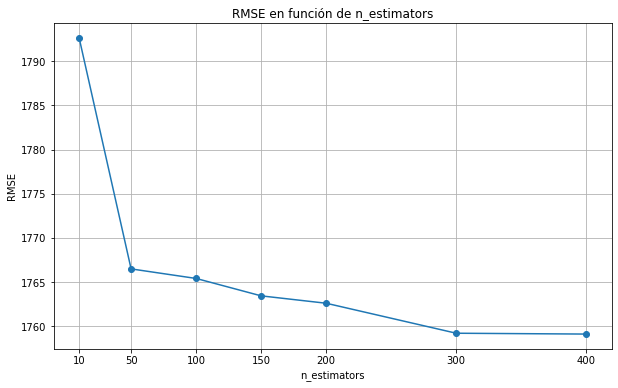

In [16]:
import matplotlib.pyplot as plt

# Listas para almacenar los valores de n_estimators y RMSE
n_estimators_values = [10, 50, 100, 150, 200, 300, 400]
rmse_values = []

# Itera sobre los valores de n_estimators para obtener los RMSE
for n_estimators in n_estimators_values:
    # Calcula el RMSE para el modelo con el valor actual de n_estimators
    random_forest_model_calibrando = RandomForestRegressor(n_estimators=n_estimators, max_depth=None, random_state=42)
    random_forest_model_calibrando.fit(X_train, y_train)
    y_pred_rf_calibrando = random_forest_model_calibrando.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_calibrando))
    rmse_values.append(rmse)

# Crea el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, rmse_values, marker='o', linestyle='-')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE en función de n_estimators')
plt.xticks(n_estimators_values)
plt.grid(True)

plt.show()




Como se puede ver en la gráfica, cuando la cantidad de estimadores llega a 300, el RMSE se mantiene casi intacto, por lo que por términos de complejidad, elijiriamos 300 como la cantidad de estimadores.

<function matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs)>

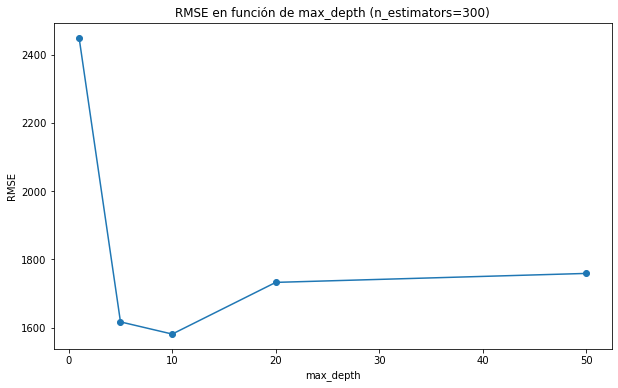

In [17]:
import matplotlib.pyplot as plt

# Listas para almacenar los valores de max_depth y RMSE
max_depth_values = [None, 1, 5, 10, 20, 50]
rmse_values = [] 

# Valor fijo de n_estimators
n_estimators = 300

# Itera sobre los valores de max_depth para obtener los RMSE
for max_depth in max_depth_values:
    # Calcula el RMSE para el modelo con el valor actual de max_depth
    random_forest_model_calibrando = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    random_forest_model_calibrando.fit(X_train, y_train)
    y_pred_rf_calibrando = random_forest_model_calibrando.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_calibrando))
    rmse_values.append(rmse)

# Crea el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, rmse_values, marker='o', linestyle='-')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title(f'RMSE en función de max_depth (n_estimators={n_estimators})')
plt.xticks


Ahora calibrando la profundidad del árbol dejando fijo la cantidad de estimadores, podemos ver, como ya lo suponíamos, que el RMSE mejora hasta que llega a un nivel de 10, por lo que esta sería la profundidad elegida, ya que incluso tiene un mejor RMSE que al elegir None en el parámetro max_depth, lo que indica que es mejor limitar la profundidad del árbol, en vez de dejarlo que crezca demasiado hasta el nivel que pueda existir overfitting.

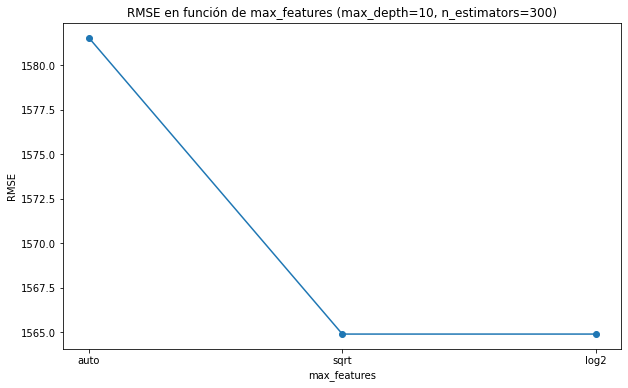

In [18]:
# Listas para almacenar los valores de max_features y RMSE
# Listas para almacenar los valores de max_features y RMSE
max_features_values = ['auto', 'sqrt', 'log2']
rmse_values = [] 

# Valor fijo de max_depth
max_depth = 10

# Valor fijo de n_estimators
n_estimators = 300

# Itera sobre los valores de max_features para obtener los RMSE
for max_features in max_features_values:
    # Calcula el RMSE para el modelo con el valor actual de max_features
    random_forest_model_calibrando = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, random_state=42)
    random_forest_model_calibrando.fit(X_train, y_train)
    y_pred_rf_calibrando = random_forest_model_calibrando.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_calibrando))
    rmse_values.append(rmse)

# Crea el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(max_features_values, rmse_values, marker='o', linestyle='-')
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.title(f'RMSE en función de max_features (max_depth={max_depth}, n_estimators={n_estimators})')
plt.xticks(max_features_values)  # Ajusta las etiquetas del eje x

plt.show()



La opción auto (todas las características o None) muestra un mayor RMSE, mientras que la raíz cuadrada y el logaritmo muetran un mejor RMSE.

In [19]:
#Ahora entrenamos el modelo Random Forest con los mejores parámetros identificados
random_forest_model_calibrado = RandomForestRegressor(n_estimators=300, max_features = "sqrt", max_depth = 10, random_state=42)
random_forest_model_calibrado.fit(X_train, y_train)
y_pred_rf_calibrado = random_forest_model_calibrado.predict(X_test)

# Métricas de desempeño para el modelo Random Forest
rmse_rf_calibrado = np.sqrt(mean_squared_error(y_test, y_pred_rf_calibrado))
r2_rf_calibrado = r2_score(y_test, y_pred_rf_calibrado)
mae_rf_calibrado = mean_absolute_error(y_test, y_pred_rf_calibrado)
# Impresión de resultados
print(f"Resultados del modelo Random Forest:\nRMSE: {rmse_rf_calibrado:.2f}, R^2: {r2_rf_calibrado:.2f}, MAE: {mae_rf_calibrado:.2f}")

Resultados del modelo Random Forest:
RMSE: 1564.89, R^2: 0.84, MAE: 1147.09


Como era de esperarse, el modelo RF calibrado presenta mejores resultados, con mejor RMSE y MAE, y un R2 4% mejor pasando de 0.80 a 0.84. RMSE y MAE mejoraron igualmente. 

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [20]:
!pip install xgboost

In [21]:
# Celda 6
# Importación y definición de modelo XGBClassifier
from xgboost import XGBRegressor
XGB = XGBRegressor(n_estimators=100, max_depth=None, learning_rate=0.1)
XGB

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
from sklearn import metrics

# Entrena el modelo con los datos de entrenamiento
XGB.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred_XGB = XGB.predict(X_test)

# Calcula las métricas de evaluación
rmse_XGB = np.sqrt(metrics.mean_squared_error(y_test, y_pred_XGB))
mae_XGB = metrics.mean_absolute_error(y_test, y_pred_XGB)
r2_XGB = metrics.r2_score(y_test, y_pred_XGB)

print(f"Resultados del modelo XGBoosting:\nRMSE: {rmse_XGB:.2f}, R^2: {r2_XGB:.2f}, MAE: {mae_XGB:.2f}")

Resultados del modelo XGBoosting:
RMSE: 1563.30, R^2: 0.84, MAE: 1146.63


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [23]:
# Celda 7
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn import metrics

# Definición del modelo XGBRegressor
xgb = XGBRegressor(n_estimators=100, max_depth=None)

# Definición del diccionario de parámetros para GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Ejecución de la búsqueda
grid_search.fit(X_train, y_train)

# Usar el mejor modelo para hacer predicciones
best_xgb = grid_search.best_estimator_
y_pred_XGB = best_xgb.predict(X_test)

# Calcula las métricas de evaluación
rmse_XGB_cal = np.sqrt(metrics.mean_squared_error(y_test, y_pred_XGB))
mae_XGB_cal = metrics.mean_absolute_error(y_test, y_pred_XGB)
r2_XGB_cal = metrics.r2_score(y_test, y_pred_XGB)

# Mostrar resultados
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Resultados del modelo XGBoosting calibrado:\nRMSE: {rmse_XGB_cal:.2f}, R^2: {r2_XGB_cal:.2f}, MAE: {mae_XGB_cal:.2f}")



Fitting 3 folds for each of 27 candidates, totalling 81 fits
Mejores parámetros: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1}
Resultados del modelo XGBoosting calibrado:
RMSE: 1544.83, R^2: 0.84, MAE: 1134.58


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

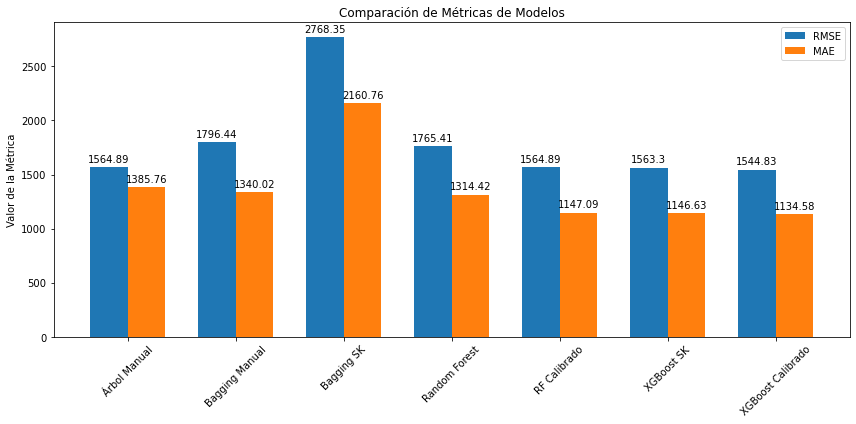

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de RMSE para cada modelo
rmse_values = [
    rmse,                # Árbol manual
    rmse_bagm,           # Bagging manual
    rmse_bagging,        # Bagging con scikit-learn
    rmse_rf,             # Random forest
    rmse_rf_calibrado,   # Random forest calibrado
    rmse_XGB,            # XGBoost con scikit-learn
    rmse_XGB_cal         # XGBoost calibrado
]

# Datos de MAE para cada modelo
mae_values = [
    mae,                # Árbol manual
    mae_bagm,           # Bagging manual
    mae_bagging,        # Bagging con scikit-learn
    mae_rf,             # Random forest
    mae_rf_calibrado,   # Random forest calibrado
    mae_XGB,            # XGBoost con scikit-learn
    mae_XGB_cal         # XGBoost calibrado
]

# Nombres de los modelos
model_names = ['Árbol Manual', 'Bagging Manual', 'Bagging SK', 'Random Forest', 'RF Calibrado', 'XGBoost SK', 'XGBoost Calibrado']

# Configuración del gráfico
x = np.arange(len(model_names))  # Ejes x para los grupos de barras
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, rmse_values, width, label='RMSE')
rects2 = ax.bar(x + width/2, mae_values, width, label='MAE')

# Añadir algunas etiquetas y título
ax.set_ylabel('Valor de la Métrica')
ax.set_title('Comparación de Métricas de Modelos')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()

# Función para añadir etiquetas de datos en las barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 puntos de offset vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()



In [25]:
# Diccionario de métricas para cada modelo
model_metrics = {
    'Árbol Manual': {
        'RMSE': rmse,
        'MAE': mae
    },
    'Bagging Manual': {
        'RMSE': rmse_bagm,
        'MAE': mae_bagm
    },
    'Bagging SK': {
        'RMSE': rmse_bagging,
        'MAE': mae_bagging
    },
    'Random Forest': {
        'RMSE': rmse_rf,
        'MAE': mae_rf
    },
    'RF Calibrado': {
        'RMSE': rmse_rf_calibrado,
        'MAE': mae_rf_calibrado
    },
    'XGBoost SK': {
        'RMSE': rmse_XGB,
        'MAE': mae_XGB
    },
    'XGBoost Calibrado': {
        'RMSE': rmse_XGB_cal,
        'MAE': mae_XGB_cal
    }
}

# Imprimir el diccionario de métricas
for model, metrics in model_metrics.items():
    print(f"{model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")


Árbol Manual:
  RMSE: 1564.8947137102093
  MAE: 1385.7565823262885
Bagging Manual:
  RMSE: 1796.4355868399332
  MAE: 1340.0160739030025
Bagging SK:
  RMSE: 2768.3504147769763
  MAE: 2160.762049592191
Random Forest:
  RMSE: 1765.4118259983413
  MAE: 1314.4207078056425
RF Calibrado:
  RMSE: 1564.8947137102093
  MAE: 1147.0872891648726
XGBoost SK:
  RMSE: 1563.2979537272195
  MAE: 1146.633512642312
XGBoost Calibrado:
  RMSE: 1544.8340760527965
  MAE: 1134.5761896358076


### Conclusiones:

Como vemos los resultados para el mejor desempeño general es para el XGBoost Calibrado, este muestra el mejor desempeño general con el menor RMSE y MAE de todos los modelos evaluados. Esto indica que la calibración de parámetros ha sido efectiva en mejorar la precisión del modelo. 
Por otra parte si comparamos con modelos no calibrados tanto XGBoost SK como RF Calibrado y el Árbol Manual tienen un desempeño similar en términos de RMSE, pero el XGBoost calibrado supera ligeramente a estos modelos.
En términos de MAE, el XGBoost Calibrado también supera a todos los demás modelos, lo que sugiere que es más consistente en la predicción de valores cercanos a los reales sin grandes desviaciones. 
En este caso es importante tambien ver otras metricas que nos puedan ayudar a decidir como lo seria un r2